In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.gridspec as gridspec
import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pylab as pl
import scipy as sp
import pymc.graph
from graphviz import Digraph
import pydot
from IPython.display import Image
import pandas as pd

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def mcmc_to_dataframe(mcmc):
    df1 = pd.DataFrame(data=[s.trace.gettrace() if len(s.trace.gettrace().shape)==1 else s.trace.gettrace()[:,0] for s in mcmc.variables])
    df2 = df1.T
    df2.columns = [s.trace.name for s in mcmc.variables]
    return df2




In [3]:
N = 1
total_int_calls_minutes_dist = pm.HalfNormal("total_int_calls_minutes_dist", tau=1.0/10000, size=N)
total_int_calls_minutes = pm.Lambda('total_int_calls_minutes', lambda tm=total_int_calls_minutes_dist: 50+tm) 
# intl_calls_price_per_min = pm.Lognormal("intl_calls_price_per_min",mu=0.0, tau=10.0, size=N)

no_pack_ppm = 2
intl_pack_list = [(0,'no_pack',0,no_pack_ppm), (1,'pack50',50,1), (2,'pack150',150,0.8), (3,'pack225',225,0.6), (4,'pack400',400,0.4)]
intl_pack_labels = map(lambda p: p[1],intl_pack_list)

# init_pack_dist = [.2, .2, .2, .2, .2]
# init_pack_dist = [.6, .1, .1, .1, .1]
init_pack_dist = [.8, .05, .05, .05, .05]
intl_pack_id = pm.Categorical("intl_pack_id",init_pack_dist, size=N)

def get_act_price(total_min, pack_min, pack_ppm):
    pack_charge = pack_min*pack_ppm
    over_pack_charge = max(0,total_min - pack_min)*no_pack_ppm
    act_price = (pack_charge+over_pack_charge)/max(1,total_min) 
    return act_price


def price_complaints(act_price, total_min):    
#     return np.maximum(0.01,np.log(act_price*10))
#     return np.maximum(0.01,np.log(act_price*total_min/10))
    return np.maximum(0.01,np.log(np.minimum(act_price*total_min, act_price*5)))

def churn_prob(num_complaints):
    return 1/(1+np.exp(7-3*num_complaints))

price_complaints_number_before = pm.Lambda('price_complaints_number_before', \
                                           lambda total_min=total_int_calls_minutes, \
                                                   curr_pack_id=intl_pack_id,  \
                                                   pack_list=intl_pack_list:\
                                            price_complaints(get_act_price(total_min, intl_pack_list[curr_pack_id][2], intl_pack_list[curr_pack_id][3]), total_min))

is_offered = pm.Bernoulli("is_offered", p=0.5, size=N)

@pm.deterministic
def package_offer(offer=is_offered, total_min=total_int_calls_minutes, curr_pack_id=intl_pack_id, pack_list=intl_pack_list):    
    curr_pack = pack_list[curr_pack_id]    
    if(offer):
        packs_calc = map(lambda pack: (pack, get_act_price(total_min, pack[2], pack[3])),pack_list)
        curr_pack = min(packs_calc, key = lambda x: x[1])[0]        
    return curr_pack

@pm.deterministic
def intl_actual_price_per_min(curr_pack=package_offer, total_min=total_int_calls_minutes, pack_list=intl_pack_list):
    real_price_ratio = get_act_price(total_min, curr_pack[2], curr_pack[3])
    return real_price_ratio


price_complaints_number_after = pm.Lambda('price_complaints_number_after', lambda act_price=intl_actual_price_per_min, total_min=total_int_calls_minutes:  price_complaints(act_price, total_min))

    


# churn_p_before = pm.Lambda('churn_p_before', lambda nc=price_complaints_number_before: churn_prob(nc))
# is_churn_before = pm.Bernoulli("is_churn_before",churn_p_before,size=N) 
churn_p = pm.Lambda('churn_p', lambda nc=price_complaints_number_after: churn_prob(nc))
is_churn = pm.Bernoulli("is_churn",churn_p,size=N) 

    

    
    
        


In [4]:
model = pm.Model([total_int_calls_minutes,
#                   intl_calls_price_per_min,
#                   intl_pack_list,
                  intl_pack_id,
                  price_complaints_number_before,
                  is_offered,
                  package_offer,                  
                  intl_actual_price_per_min,
                  price_complaints_number_after,
                  churn_p,
                  is_churn
                 ])

mcmc = pm.MCMC(model)
mcmc.sample(20000,500)

 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

In [5]:
init_pack = mcmc.trace('intl_pack_id')[:,0]
offered = mcmc.trace('is_offered')[:,0]
calls_minutes = mcmc.trace('total_int_calls_minutes')[:,0]
act_ppm = mcmc.trace('intl_actual_price_per_min')[:]
complaints_before = mcmc.trace('price_complaints_number_before')[:]
complaints_after = mcmc.trace('price_complaints_number_after')[:]
pack_offer = mcmc.trace('package_offer')[:,0]
churn_p =mcmc.trace('churn_p')[:]
churn =mcmc.trace('is_churn')[:,0]


In [6]:
%matplotlib inline

xx = pymc.graph.dag(model)
# xx.write_png('model_graph.png', prog='dot')


Image('model_graph.png')

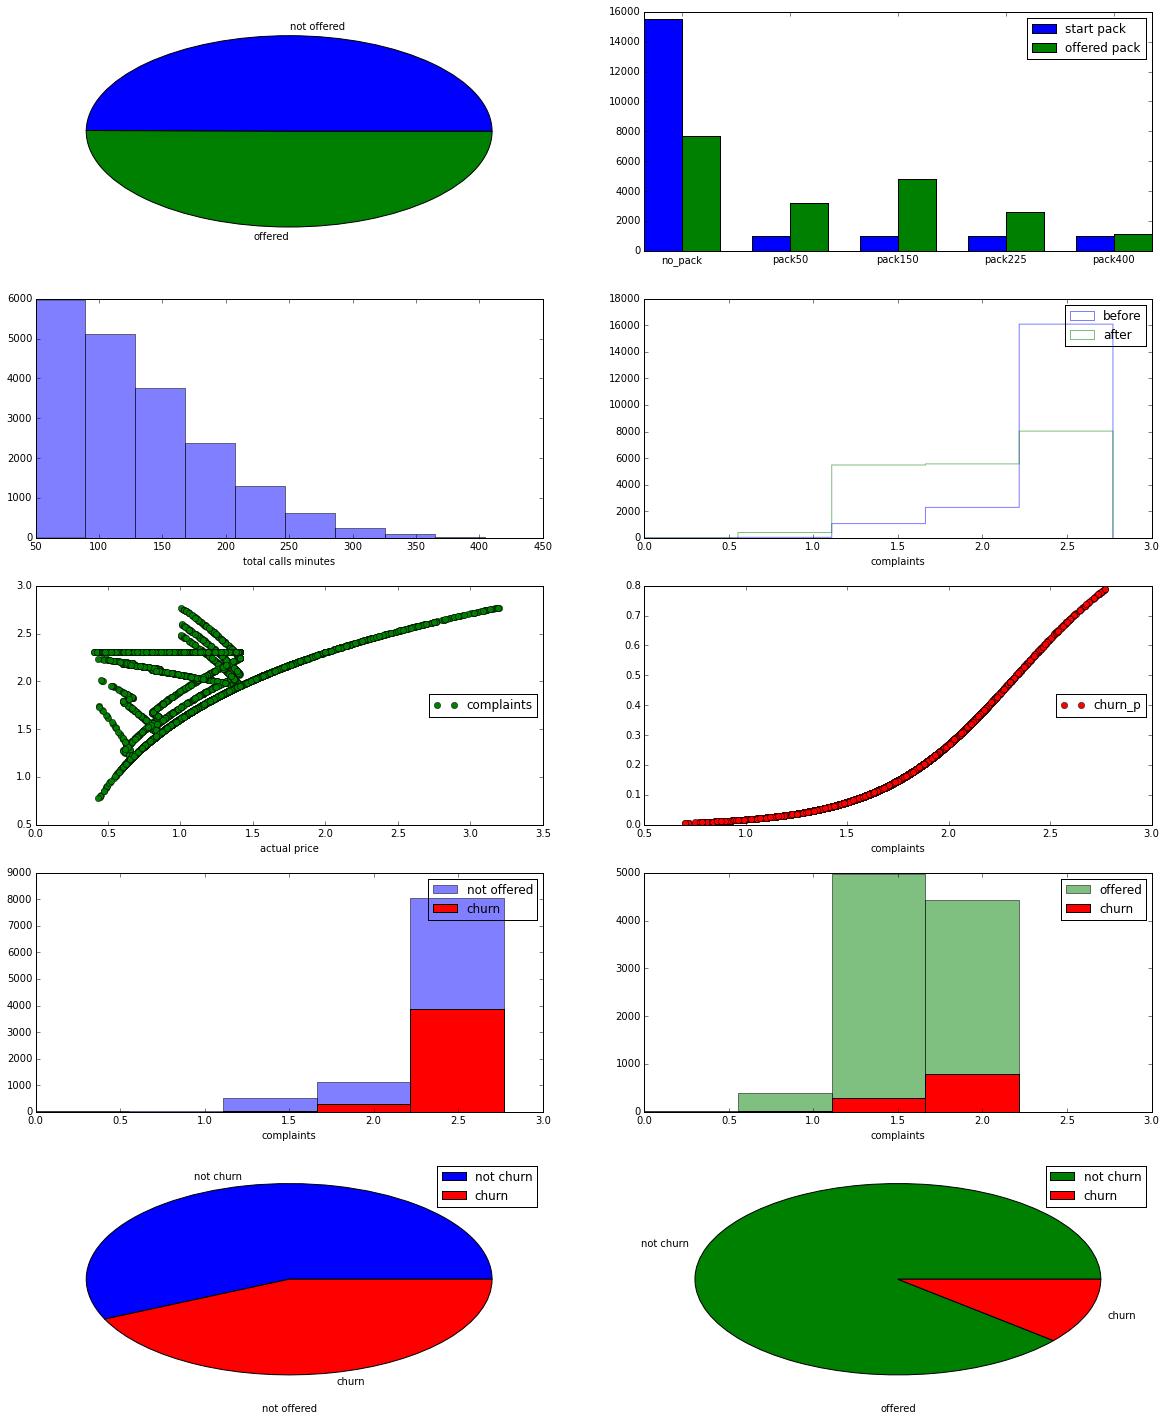

In [7]:
# {'bar', 'barstacked', 'step',  'stepfilled'}
figsize(20,30)
NN=5000
rows = 6
cols =2
i = range(1,cols*rows)
i.reverse()

complaints_bins = np.linspace(0, max(complaints_before),6)


plt.subplot(rows, cols,i.pop())
plt.pie(np.histogram(offered, bins=2)[0], labels=['not offered', 'offered'])


plt.subplot(rows,cols,i.pop())
index = np.arange(len(intl_pack_labels))
bar_width = 0.35
plt.xticks(index + bar_width, intl_pack_labels)
plt.bar(index, sp.stats.itemfreq(init_pack)[:,1].astype(int),bar_width,label='start pack')
plt.bar(index+bar_width, sp.stats.itemfreq(pack_offer)[:,1].astype(int),bar_width,label='offered pack',color='g')
plt.legend(loc='upper right')

# plt.subplot(rows,cols,i.pop())
# plt.hist(complaints_before[~offered], bins=complaints_bins, alpha=0.5, label='not offered',histtype='bar')
# plt.hist(complaints_before[offered], bins=complaints_bins, alpha=0.5, label='offered', histtype='bar')
# plt.xlabel("complaints before")
# plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.hist(calls_minutes, bins=10, alpha=0.5, label='count',histtype='bar')
plt.xlabel('total calls minutes')


plt.subplot(rows,cols,i.pop())
plt.hist(complaints_before, bins=complaints_bins, alpha=0.5, label='before',histtype='step')
plt.hist(complaints_after, bins=complaints_bins, alpha=0.5, label='after', histtype='step')
plt.xlabel("complaints")
plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.plot(act_ppm, complaints_before, 'og',label='complaints')
plt.xlabel("actual price")
plt.legend(loc='right')


plt.subplot(rows,cols,i.pop())
plt.plot(complaints_after, churn_p, 'or',label='churn_p')
plt.xlabel("complaints")
plt.legend(loc='right')

# plt.subplot(rows,cols,i.pop())
# plt.hist(complaints_after[~offered], bins=complaints_bins, alpha=0.5, label='not offered',histtype='bar')
# plt.hist(complaints_after[offered], bins=complaints_bins, alpha=0.5, label='offered', histtype='bar')
# plt.xlabel("complaints after")
# plt.legend(loc='upper right')



# ax1 = plt.subplot(rows,cols,i.pop())
# h1=ax1.hist(complaints_after[churn], bins=complaints_bins, alpha=0.5, label='churn', histtype='bar', color='red')
# h2=ax1.hist(complaints_after[~churn], bins=complaints_bins, alpha=0.5, label='not churn',histtype='bar')
# ax1.set_xlabel("complaints")
# ax1.legend(loc='upper right')
# ax2 = ax1.twinx()
# l1=ax2.plot(complaints_after, churn_p, '.r',label='churn_p')
# ax2.set_ylabel('churn_p')
# ax2.legend(loc='right')





plt.subplot(rows,cols,i.pop())
plt.hist(complaints_after[~offered], bins=complaints_bins, alpha=0.5, label='not offered',histtype='bar', color='b')
plt.hist(complaints_after[churn & ~offered], bins=complaints_bins, alpha=1, label='churn', histtype='bar', color='r')
plt.xlabel("complaints")
plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.hist(complaints_after[offered], bins=complaints_bins, alpha=0.5, label='offered',histtype='bar', color='g')
plt.hist(complaints_after[churn & offered], bins=complaints_bins, alpha=1, label='churn', histtype='bar', color='red')
plt.xlabel("complaints")
plt.legend(loc='upper right')


# plt.subplot(rows,cols,i.pop())
# plt.hist(complaints_after[churn & offered], bins=1, alpha=0.2, label='churn offered', histtype='bar', color='green')
# plt.hist(complaints_after[churn & ~offered], bins=1, alpha=0.2, label='churn not offered',histtype='bar', color='blue')

plt.subplot(rows,cols,i.pop())
plt.pie(np.histogram(churn[~offered], bins=2)[0], labels=['not churn', 'churn'], colors=['b','r'])
plt.xlabel("not offered")
plt.legend(loc='upper right')

plt.subplot(rows,cols,i.pop())
plt.pie(np.histogram(churn[offered], bins=2)[0], labels=['not churn', 'churn'], colors=['g','r'])
plt.xlabel("offered")
plt.legend(loc='upper right')




# plt.subplot(rows,cols,i.pop())
# plt.hist(pack_offer,50,label='after pack')
# plt.legend(loc='lower right')



In [100]:
total_min=100


packs_calc = map(lambda pack: (pack, get_act_price(total_min, pack[2], pack[3])),intl_pack_list)
print packs_calc
min(packs_calc, key = lambda x: x[1])[0]

[((0, 'no_pack', 0, 2), 2), ((1, 'pack50', 50, 1), 1), ((2, 'pack150', 150, 0.8), 1.2), ((3, 'pack225', 225, 0.6), 1.35), ((4, 'pack400', 400, 0.4), 1.6)]


(1, 'pack50', 50, 1)

In [67]:
# plt.subplot(rows,cols,i.pop())
# complaints_bins = np.linspace(0, max(complaints_after),4)
# compl__not_off = np.histogram(complaints_after[~offered], bins=complaints_bins)
# compl__off = np.histogram(complaints_after[offered], bins=complaints_bins)
# plt.bar(compl__not_off[1][compl__not_off[1]>0], compl__not_off[0], color='y')
# plt.bar(compl__off[1][compl__off[1]>0], compl__off[0], color='g')
# plt.xlabel("complaints after")
# plt.legend(loc='upper right')

In [105]:
from numpy import exp,arange, argsort
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

def price_complaints(act_price, total_min):
#     return act_price*total_min
#     return np.log(act_price*total_min)
#     return np.maximum(0.01,np.log(act_price*total_min/20))
    return np.maximum(0.01,np.log(np.minimum(act_price*total_min/30, act_price*5)))

def churn_prob(num_complaints):
    return 1/(1+np.exp(7-3*num_complaints))

N = 50000
# call_minutes = pm.rhalf_normal(tau=1.0/10000, size=N)
call_minutes = arange(0,300, 1)
min_price = arange(0.01,10, 1)
X,Y = meshgrid(call_minutes, min_price) # grid of point

# points = zip(calls_minutes, act_ppm)
# sorted_points = np.sort(points)
# new_xs = [point[0] for point in sorted_points]
# new_ys = [point[1] for point in sorted_points]
# X,Y = meshgrid(new_xs[:500], new_ys[:500]) 

Z = price_complaints(X, Y) # evaluation of the function on the grid

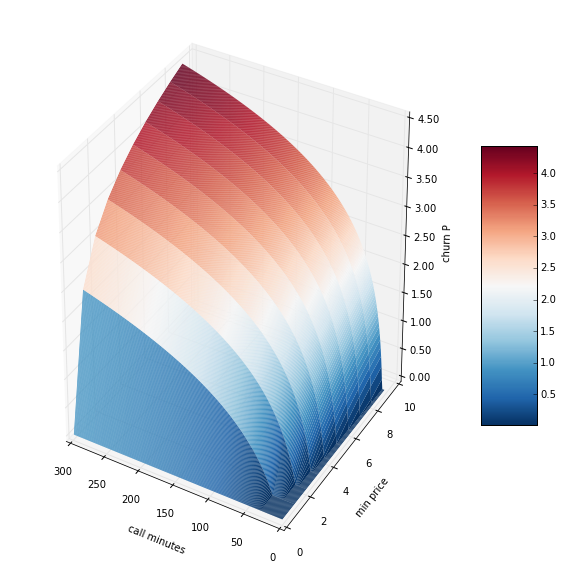

In [106]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

fig = plt.figure(figsize(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu_r,linewidth=0, antialiased=True)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.invert_xaxis()
# ax.invert_zaxis()
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('call minutes')
ax.set_ylabel('min price')
ax.set_zlabel('churn P')

plt.show()

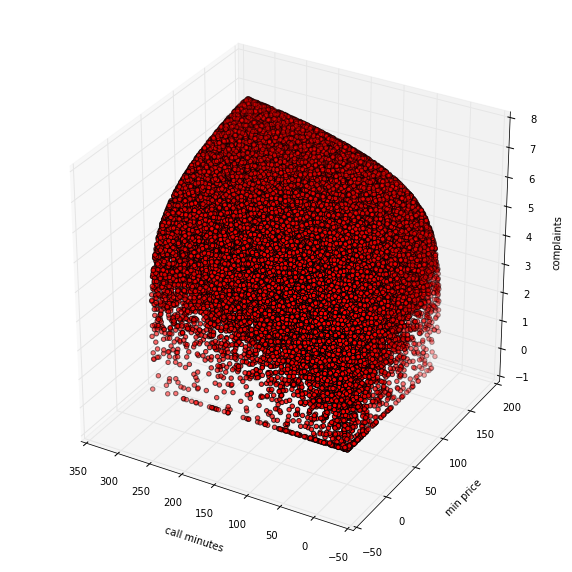

In [107]:

N = 50000
# call_minutes = pm.rhalf_normal(tau=1.0/10000, size=N)
call_minutes = pm.runiform(0,300, size=N)
min_price = pm.runiform(0.01,160, size=N)
compl = [price_complaints(m,p) for m,p in zip(call_minutes,min_price)]

fig = plt.figure(figsize(10,10))
ax = fig.add_subplot(111, projection='3d')

xs = call_minutes
ys = min_price
zs =compl


ax.scatter(xs, ys, zs, zdir=u'z', c='r', marker='o')

ax.invert_xaxis()
ax.set_xlabel('call minutes')
ax.set_ylabel('min price')
ax.set_zlabel('complaints')

plt.show()